In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

import numpy as np
import matplotlib.pyplot as plt
import random

In [29]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
AUTO = tf.data.AUTOTUNE

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_valid)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

169001437/169001437 [==============================] - 13s 0us/step
Training samples: 50000
Testing samples: 10000


In [30]:
IMAGE_SIZE = 48
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [31]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [32]:
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 6.


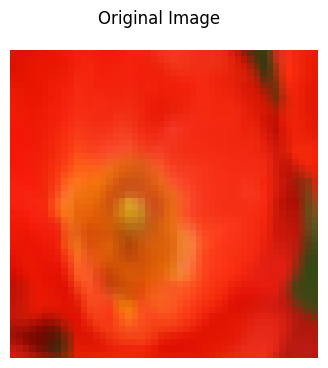

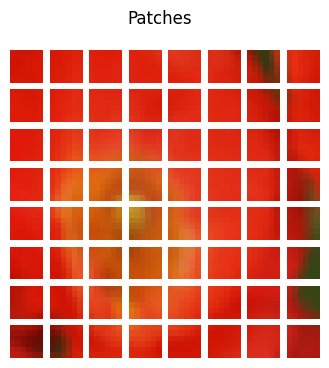

In [33]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

In [34]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [35]:
EPOCHS = 250
DOWNSTREAM_EPOCHS = 250

In [36]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [37]:
def dense_projection(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [38]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [39]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = L.Flatten()(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [40]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)


        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):

        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [41]:
test_images = next(iter(valid_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)


            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [42]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)


mae_model.compile(
    optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

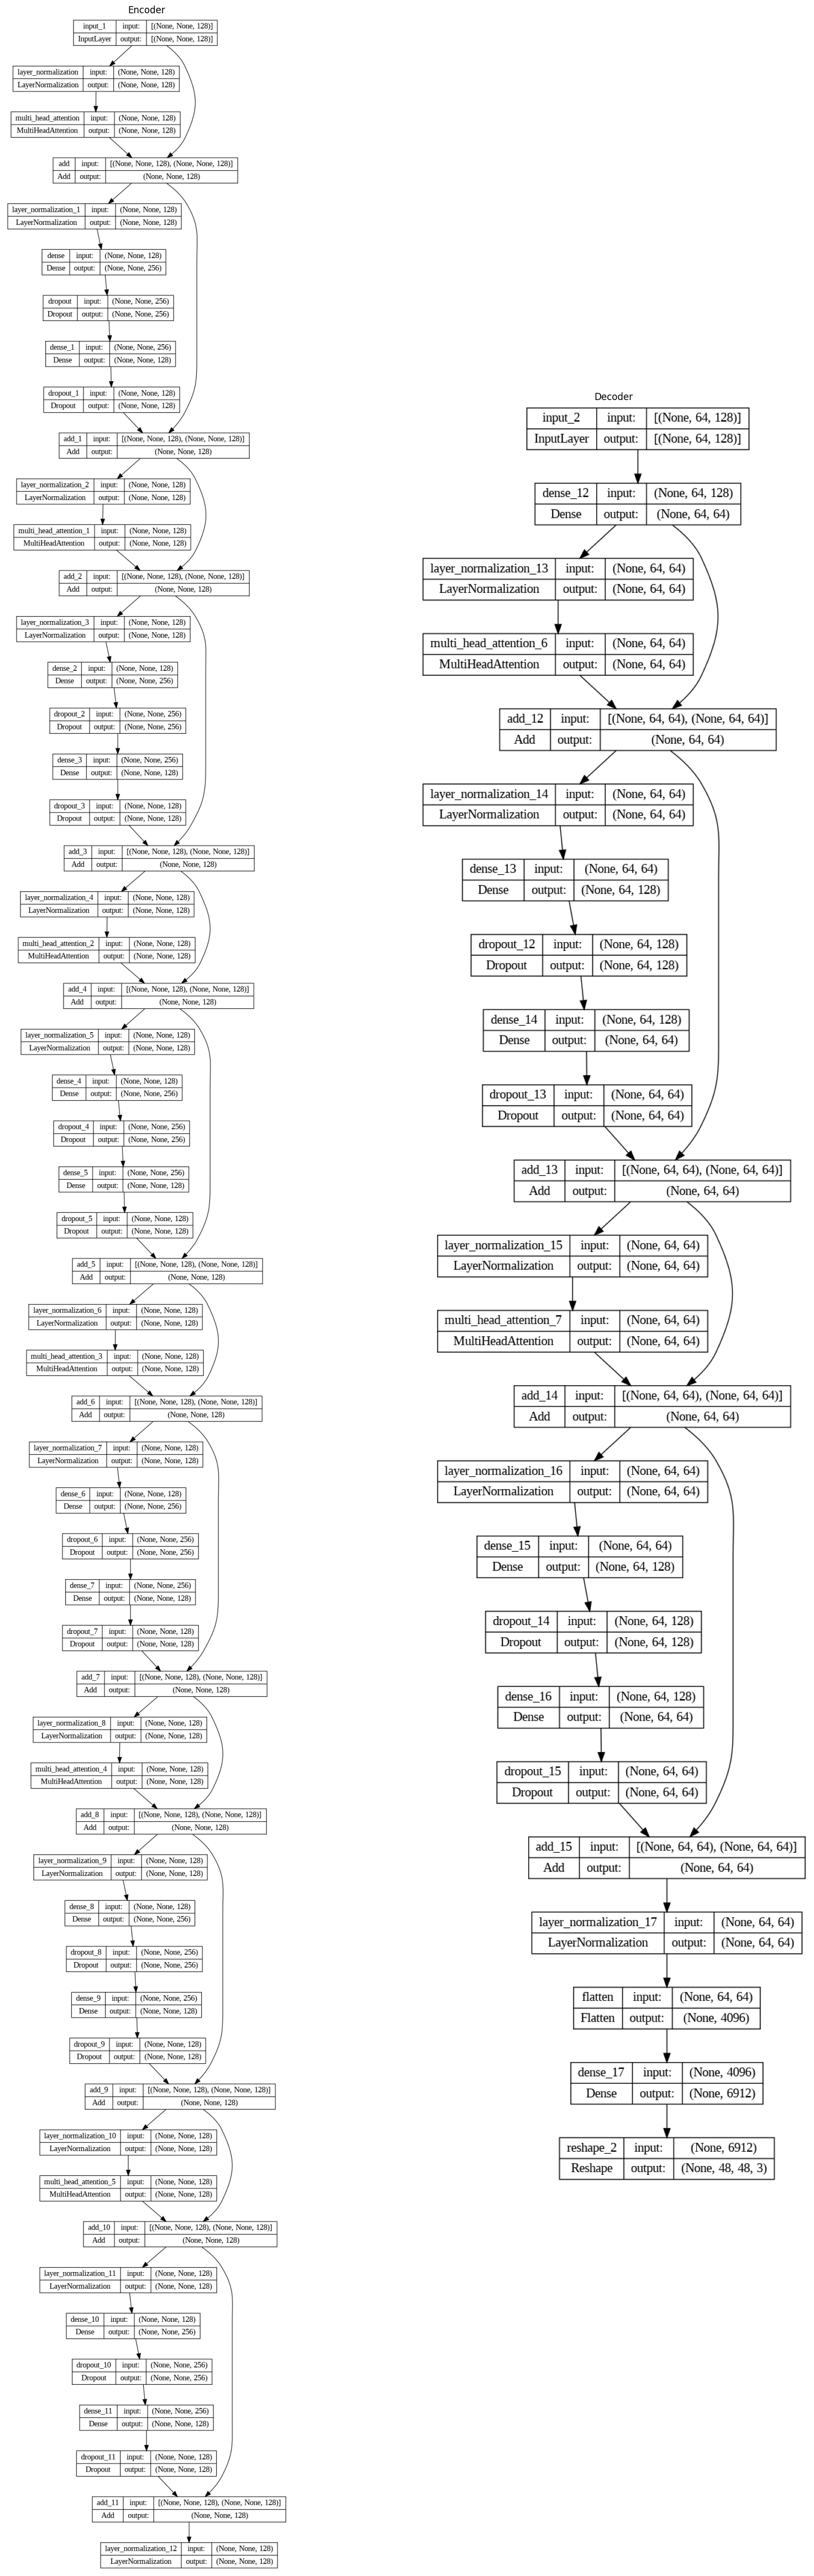

In [43]:
keras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")
keras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 60))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=12)
ax[0].axis("off")
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=12)
ax[1].axis("off");

Epoch 1/250
195/196 [============================>.] - ETA: 0s - loss: 0.0467 - mae: 0.1725
Idx chosen: 0


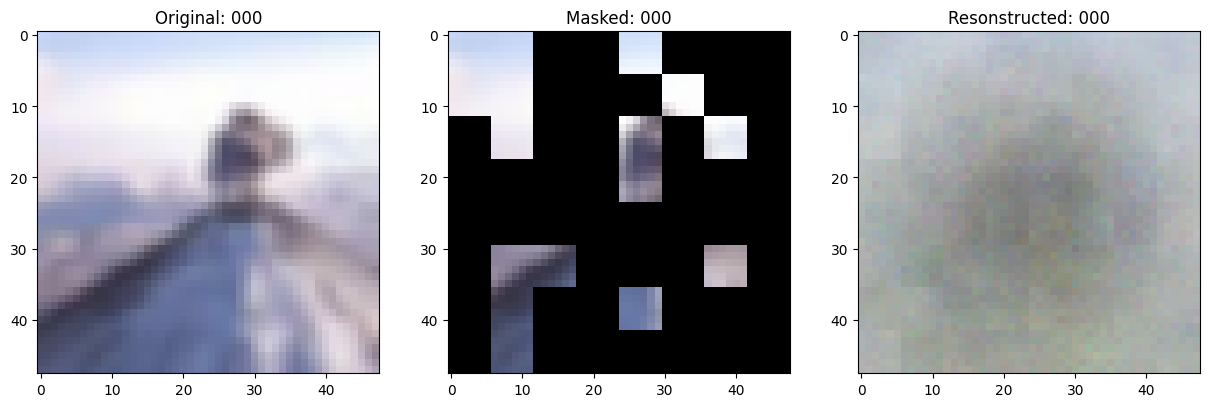

196/196 [==============================] - 37s 55ms/step - loss: 0.0467 - mae: 0.1725 - val_loss: 0.0430 - val_mae: 0.1664 - lr: 0.0010
Epoch 2/250
196/196 [==============================] - 9s 46ms/step - loss: 0.0398 - mae: 0.1573 - val_loss: 0.0371 - val_mae: 0.1505 - lr: 0.0010
Epoch 3/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0347 - mae: 0.1443 - val_loss: 0.0331 - val_mae: 0.1408 - lr: 0.0010
Epoch 4/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0317 - mae: 0.1365 - val_loss: 0.0313 - val_mae: 0.1348 - lr: 0.0010
Epoch 5/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0297 - mae: 0.1310 - val_loss: 0.0294 - val_mae: 0.1294 - lr: 0.0010
Epoch 6/250
195/196 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.1254
Idx chosen: 39


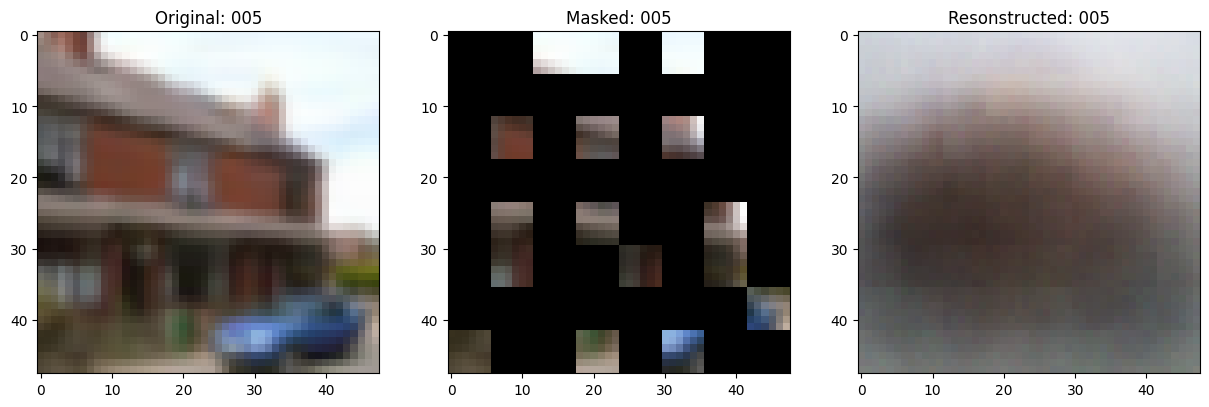

196/196 [==============================] - 9s 47ms/step - loss: 0.0276 - mae: 0.1254 - val_loss: 0.0277 - val_mae: 0.1266 - lr: 0.0010
Epoch 7/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0259 - mae: 0.1208 - val_loss: 0.0257 - val_mae: 0.1204 - lr: 0.0010
Epoch 8/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0241 - mae: 0.1157 - val_loss: 0.0241 - val_mae: 0.1145 - lr: 0.0010
Epoch 9/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0229 - mae: 0.1123 - val_loss: 0.0231 - val_mae: 0.1124 - lr: 0.0010
Epoch 10/250
196/196 [==============================] - 9s 43ms/step - loss: 0.0217 - mae: 0.1089 - val_loss: 0.0223 - val_mae: 0.1108 - lr: 0.0010
Epoch 11/250
196/196 [==============================] - ETA: 0s - loss: 0.0211 - mae: 0.1070
Idx chosen: 27


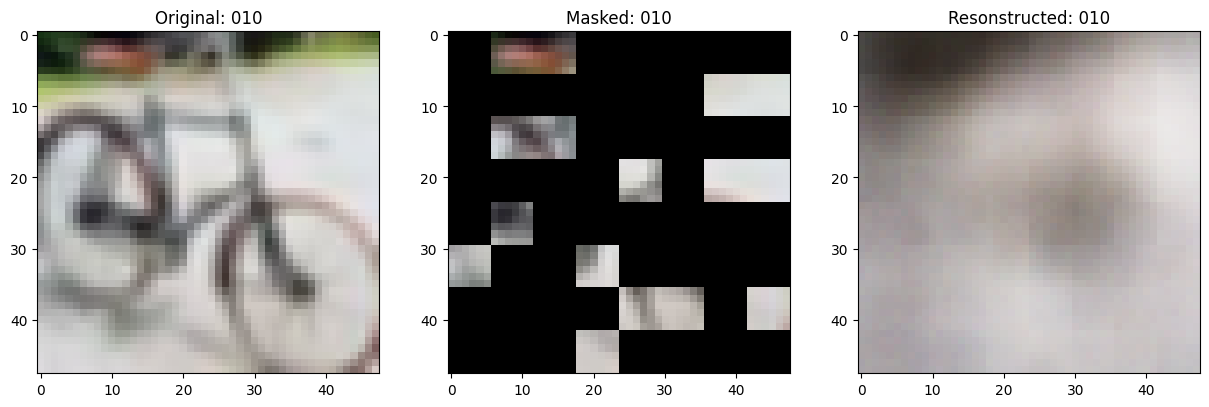

196/196 [==============================] - 9s 48ms/step - loss: 0.0211 - mae: 0.1070 - val_loss: 0.0219 - val_mae: 0.1083 - lr: 0.0010
Epoch 12/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0205 - mae: 0.1051 - val_loss: 0.0211 - val_mae: 0.1071 - lr: 0.0010
Epoch 13/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0200 - mae: 0.1036 - val_loss: 0.0207 - val_mae: 0.1056 - lr: 0.0010
Epoch 14/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0197 - mae: 0.1024 - val_loss: 0.0201 - val_mae: 0.1043 - lr: 0.0010
Epoch 15/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0193 - mae: 0.1012 - val_loss: 0.0199 - val_mae: 0.1027 - lr: 0.0010
Epoch 16/250
195/196 [============================>.] - ETA: 0s - loss: 0.0191 - mae: 0.1003
Idx chosen: 198


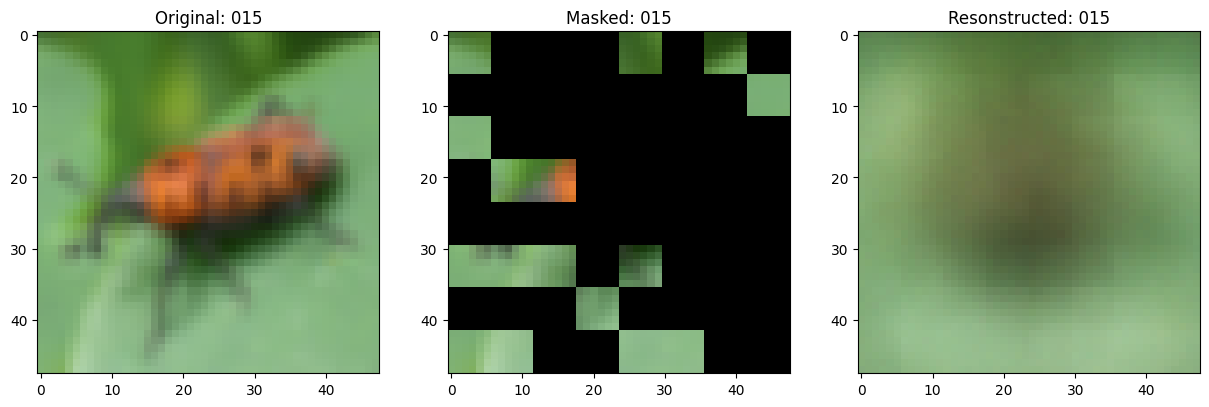

196/196 [==============================] - 9s 46ms/step - loss: 0.0191 - mae: 0.1003 - val_loss: 0.0200 - val_mae: 0.1040 - lr: 0.0010
Epoch 17/250
196/196 [==============================] - 9s 46ms/step - loss: 0.0188 - mae: 0.0996 - val_loss: 0.0193 - val_mae: 0.1009 - lr: 0.0010
Epoch 18/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0185 - mae: 0.0987 - val_loss: 0.0192 - val_mae: 0.1004 - lr: 0.0010
Epoch 19/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0183 - mae: 0.0978 - val_loss: 0.0190 - val_mae: 0.0992 - lr: 0.0010
Epoch 20/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0181 - mae: 0.0973 - val_loss: 0.0188 - val_mae: 0.0992 - lr: 0.0010
Epoch 21/250
195/196 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0966
Idx chosen: 129


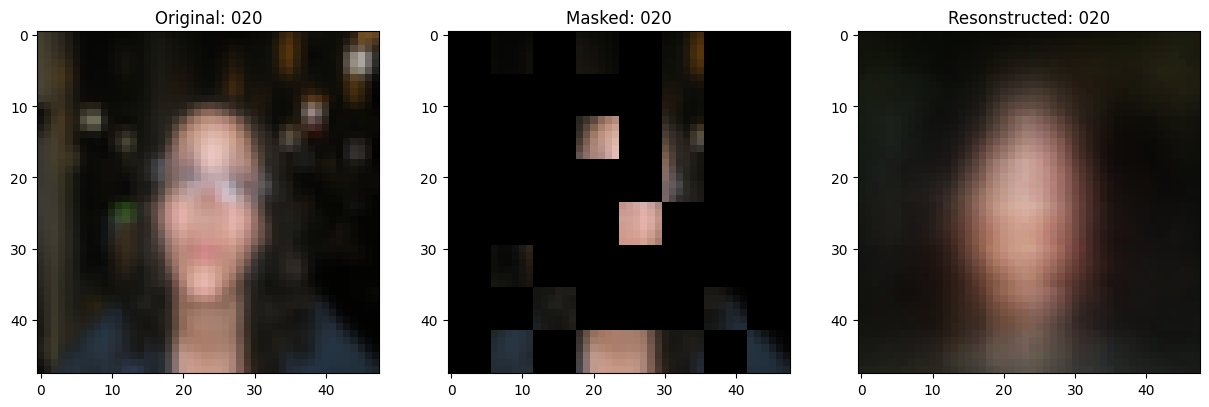

196/196 [==============================] - 9s 46ms/step - loss: 0.0179 - mae: 0.0966 - val_loss: 0.0187 - val_mae: 0.0995 - lr: 0.0010
Epoch 22/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0178 - mae: 0.0963 - val_loss: 0.0185 - val_mae: 0.0989 - lr: 0.0010
Epoch 23/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0177 - mae: 0.0959 - val_loss: 0.0185 - val_mae: 0.0981 - lr: 0.0010
Epoch 24/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0175 - mae: 0.0951 - val_loss: 0.0182 - val_mae: 0.0965 - lr: 0.0010
Epoch 25/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0174 - mae: 0.0950 - val_loss: 0.0180 - val_mae: 0.0964 - lr: 0.0010
Epoch 26/250
196/196 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0945
Idx chosen: 74


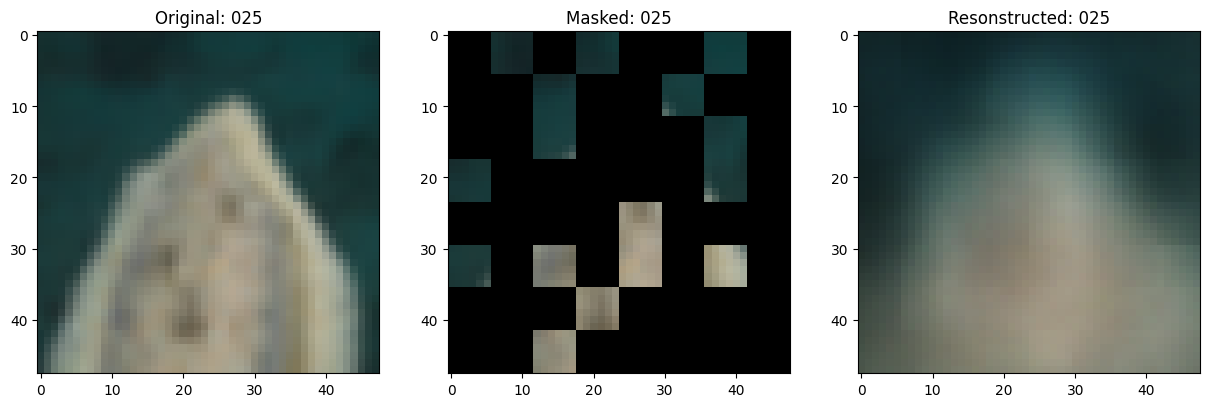

196/196 [==============================] - 9s 48ms/step - loss: 0.0173 - mae: 0.0945 - val_loss: 0.0186 - val_mae: 0.0994 - lr: 0.0010
Epoch 27/250
195/196 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0941
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
196/196 [==============================] - 9s 44ms/step - loss: 0.0172 - mae: 0.0941 - val_loss: 0.0180 - val_mae: 0.0961 - lr: 0.0010
Epoch 28/250
196/196 [==============================] - 9s 45ms/step - loss: 0.0165 - mae: 0.0911 - val_loss: 0.0171 - val_mae: 0.0927 - lr: 1.0000e-04
Epoch 29/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0163 - mae: 0.0905 - val_loss: 0.0170 - val_mae: 0.0923 - lr: 1.0000e-04
Epoch 30/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0163 - mae: 0.0905 - val_loss: 0.0169 - val_mae: 0.0924 - lr: 1.0000e-04
Epoch 31/250
195/196 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0903
Idx chosen

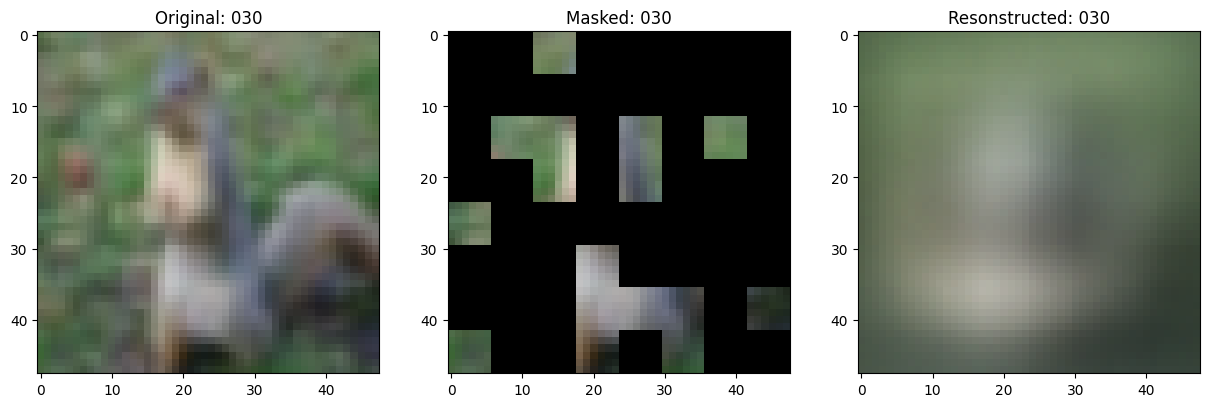

196/196 [==============================] - 9s 47ms/step - loss: 0.0162 - mae: 0.0903 - val_loss: 0.0169 - val_mae: 0.0923 - lr: 1.0000e-04
Epoch 32/250
196/196 [==============================] - ETA: 0s - loss: 0.0162 - mae: 0.0901
Epoch 32: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
196/196 [==============================] - 9s 44ms/step - loss: 0.0162 - mae: 0.0901 - val_loss: 0.0169 - val_mae: 0.0923 - lr: 1.0000e-04
Epoch 33/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0161 - mae: 0.0899 - val_loss: 0.0169 - val_mae: 0.0919 - lr: 1.0000e-05
Epoch 34/250
195/196 [============================>.] - ETA: 0s - loss: 0.0161 - mae: 0.0898
Epoch 34: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 [==============================] - 9s 44ms/step - loss: 0.0161 - mae: 0.0898 - val_loss: 0.0168 - val_mae: 0.0918 - lr: 1.0000e-05
Epoch 35/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0161 - mae

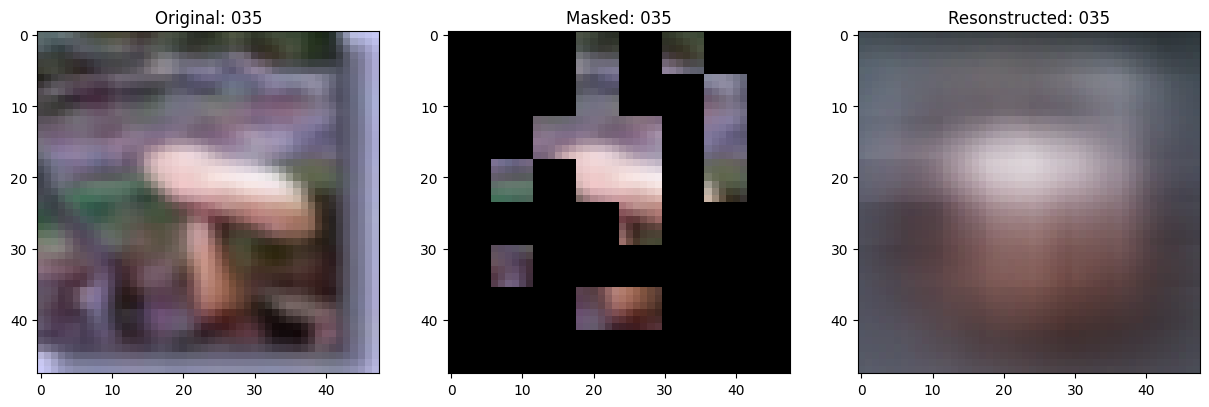

196/196 [==============================] - 9s 46ms/step - loss: 0.0161 - mae: 0.0898 - val_loss: 0.0168 - val_mae: 0.0916 - lr: 1.0000e-06
Epoch 37/250
195/196 [============================>.] - ETA: 0s - loss: 0.0161 - mae: 0.0898
Epoch 37: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
196/196 [==============================] - 9s 44ms/step - loss: 0.0161 - mae: 0.0898 - val_loss: 0.0167 - val_mae: 0.0915 - lr: 1.0000e-06
Epoch 38/250
196/196 [==============================] - 8s 43ms/step - loss: 0.0161 - mae: 0.0897 - val_loss: 0.0168 - val_mae: 0.0917 - lr: 1.0000e-07
Epoch 39/250
196/196 [==============================] - ETA: 0s - loss: 0.0161 - mae: 0.0897
Epoch 39: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
196/196 [==============================] - 9s 44ms/step - loss: 0.0161 - mae: 0.0897 - val_loss: 0.0169 - val_mae: 0.0918 - lr: 1.0000e-07
Epoch 40/250
196/196 [==============================] - 9s 44ms/step - loss: 0.0161 - mae:

In [44]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), es, rlp],
)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [45]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True

encoder = mae_model.encoder

downstream_model = keras.Sequential(
    [
        L.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        L.BatchNormalization(),
        L.GlobalAveragePooling1D(),
        L.Dense(10, activation="softmax"),
    ],
    name="downstream_model",
)

In [46]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
train_ds = prepare_data(x_train, y_train)
valid_ds = prepare_data(x_valid, y_valid, is_train=False)

170498071/170498071 [==============================] - 18s 0us/step


In [47]:
downstream_model.compile(
    optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

downstream_model.fit(train_ds, validation_data=valid_ds, epochs=DOWNSTREAM_EPOCHS, callbacks=[es, rlp])

loss, accuracy = downstream_model.evaluate(valid_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/250


196/196 [==============================] - 30s 64ms/step - loss: 1.5304 - accuracy: 0.4487 - val_loss: 1.4688 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 2/250
196/196 [==============================] - 11s 58ms/step - loss: 1.2814 - accuracy: 0.5367 - val_loss: 1.3277 - val_accuracy: 0.5304 - lr: 0.0010
Epoch 3/250
196/196 [==============================] - 12s 59ms/step - loss: 1.1915 - accuracy: 0.5732 - val_loss: 1.2117 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 4/250
196/196 [==============================] - 11s 58ms/step - loss: 1.1309 - accuracy: 0.5950 - val_loss: 1.2671 - val_accuracy: 0.5521 - lr: 0.0010
Epoch 5/250
196/196 [==============================] - 11s 58ms/step - loss: 1.0834 - accuracy: 0.6130 - val_loss: 1.1747 - val_accuracy: 0.5828 - lr: 0.0010
Epoch 6/250
196/196 [==============================] - 11s 58ms/step - loss: 1.0509 - accuracy: 0.6241 - val_loss: 1.0834 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 7/250
196/196 [==============================] - 11s 58ms/